In [1]:
#Basic analyses of Marshmallow data
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import scipy.io as sio
import pandas as pd

In [2]:
##### column name meanings #####
#testData
# % run
# % trial
# % cb: 1 = beaches nback, 2 = gazebos nback
# % category_cue: category of the cued scene and competitor (1 = beach, 2 = gazebo)
# % category_noncomp: category of the non-competitor item (1 = beach, 2 = gazebo)
# % pairnum_cue: which pair within a category the cue and competitor comes from
# % pairnum_noncomp: which pair within a category the non-competitor comes from
# % pairitem_cue: which item is being shown on this trial (pairmate 1 or pairmate 2) for the cue
# % pairitem_noncomp: which item is being shown on this trial (pairmate 1 or pairmate 2) for the non-competitor
# % pairid_cue: ID # of this pair (based on all possible combinations) for the cue and competitor
# % pairid_noncomp: ID # of this pair (based on all possible combinations) for the non-competitor
# % scenenum: which scene is being shown for the cue
# % objnum_obj1: which object is being shown for the left item
# % objnum_obj2 which object is being shown for the middle item
# % objnum_obj3: which object is being shown for the right item
# % condition_cue: similarity condition (0-4) of the cue and competitor
# % condition_noncomp: similarity condition (0-4) of the non-competitor
# % objpos1: which item appeared on the left (1 = target, 2 = competitor, 3 = non-competitor)
# % objpos2: which item appeared on the middle (1 = target, 2 = competitor, 3 = non-competitor)
# % objpos3:which item appeared on the right (1 = target, 2 = competitor, 3 = non-competitor)
# % resp: actual response
# % score: 1 = target, 2 = competitor, 3 = non-competitor
# % rt: response time (s)

#nback
# % run
# % trial
# % category: 1 = beach, 2 = gazebo
# % stim: stimulus number shown
# % cresp: correct response
# % resp: actual response
# % acc: accuracy
# % rt: response time (s)

In [3]:
##### Helpers #####

In [4]:
#helper to load data
def loadData(sn,task="both",robertData=0):
    datadir = "../data/"
    nbackData = np.empty([1000,8])
    testData = np.empty([120,23])
    subj_str = "marshmallow_"+str(sn)
    if robertData==1:
        if sn<10:
            subj_str = "marshmallow_00"+str(sn)
        else:
            subj_str = "marshmallow_0"+str(sn)
    fullpath_str = datadir+subj_str+"/"+subj_str
    if np.logical_and(robertData==1,sn==4):
        fullpath_str = datadir+subj_str+"/marshmallow_003" #dunno how this happened but I suspect it was just an error while running the code
    header = sio.loadmat(fullpath_str+"_header.mat")
    if task!='st':
        for irun in range(20):
            data = sio.loadmat(fullpath_str+"_nback_1_"+str(irun+1)+".mat")
            nbackData[(irun*50):(irun+1)*50] = data["data"]["rundata"][0][0]
        nbackData = pd.DataFrame(nbackData,columns=["run","trial","category","stim","cresp","resp","acc","rt"])
    if task!='nback':
        for irun in range(3):
            data = sio.loadmat(fullpath_str+"_studytest_"+str(irun+1)+".mat")
            testData[(irun*40):(irun+1)*40] = data["data"]["testdata"][0][0]
        testData = pd.DataFrame(testData,columns=["run","trial","cat_nb","cat_cue","cat_noncomp",
                                                    "pairnum_cue","pairnum_noncomp","pairitem_cue","pairitem_noncomp",
                                                    "pairid_cue","pairid_noncomp",
                                                    "scenenum","objnum_obj1","objnum_obj2","objnum_obj3","cond_cue",
                                                    "cond_noncomp","objpos1","objpos2","objpos3","resp","score","rt"])
    return header, nbackData, testData

In [5]:
#correct when a subject messes up their buttons in the nback (happens fairly often)
def nbackRespCorrect(nbackdata,bn):
    blockresp = nbackdata.resp[nbackdata.run==bn]
    blockcresp = nbackdata.cresp[nbackdata.run==bn]
    blockresp[blockresp==2] = 1.0
    blockresp[np.isnan(blockresp)] = 2.0
    blockacc = blockresp==blockcresp
    return blockcresp,blockresp,blockacc.astype(int)
        

In [6]:
#do some descriptive stats on the nback data
def nbackSummary(nbackdata,sn,printSubj=0):
    mean_nback_acc = np.nanmean(nbackData.acc)
    mean_nback_rt = np.nanmean(nbackData.rt)
    if printSubj:
        print("subj"+str(sn)+" mean nBack acc = "+str(mean_nback_acc))
        print("subj"+str(sn)+" mean nBack rt = "+str(mean_nback_rt))
    meanRT = np.zeros(20,dtype=float)
    meanAcc = np.zeros(20,dtype=float)
    for i in range(20):
        if i==13:
            if sn==13:
                [nbackData.resp[nbackData.run==(i+1)],nbackData.cresp[nbackData.run==(i+1)],nbackData.acc[nbackData.run==(i+1)]]=nbackRespCorrect(nbackData,i+1)
        if i==19:
            if sn==3:
                [nbackData.resp[nbackData.run==(i+1)],nbackData.cresp[nbackData.run==(i+1)],nbackData.acc[nbackData.run==(i+1)]]=nbackRespCorrect(nbackData,i+1)
        meanRT[i] = np.nanmean(nbackData.rt[nbackData.run==(i+1)])
        meanAcc[i] = np.nanmean(nbackData.acc[nbackData.run==(i+1)])
    # if printSubj:
    #     print("subj"+str(sn)+" mean block20 acc = "+str(meanAcc[13]))
    return meanRT,meanAcc

In [7]:
def studytestSummary(testData,sn,printSubj=0):
	#first, we fix this
	testData.cat_nb = testData.cat_nb - 1 
	testData.cat_cue = testData.cat_cue - 1
	testData.cat_noncomp = testData.cat_noncomp - 1
	#assign catagory labels
	learned_cat = testData.cat_nb[0]
	novel_cat = (learned_cat*-1)+1

	meanAcc = np.nansum(testData.score==1)/120
	#break it up by stimulus condition
	learned_meanAcc = np.nansum(testData.score[testData.cat_cue==learned_cat]==1)/np.nansum(testData.cat_cue==learned_cat)
	novel_meanAcc = np.nansum(testData.score[testData.cat_cue==novel_cat]==1)/np.nansum(testData.cat_cue==novel_cat)
	if printSubj:
		print("subj"+str(sn)+" mean ST acc = "+str(meanAcc))
		print("subj"+str(sn)+" learned stimulus mean acc = "+str(learned_meanAcc))
		print("subj"+str(sn)+" novel stimulus mean acc = "+str(novel_meanAcc))
		#document nan responses to make sure people are actually doing the task
		print("subj"+str(sn)+" nan responses = "+str(np.sum(np.isnan(testData.rt))))
		print("\n")
	#break it up by block
	#basic stats
	learned_acc_block = np.zeros(3)
	novel_acc_block = np.zeros(3)
	#histogram stats
	learned_num_resps = np.zeros((3,3))
	novel_num_resps = np.zeros((3,3))
	learned_rt_resps = np.zeros((3,3))
	novel_rt_resps = np.zeros((3,3))
	#rt stats
	learned_rt_block = np.zeros(3)
	novel_rt_block = np.zeros(3)
	for i in range(3):
		learned_rt_block[i] = np.nanmean(testData.rt[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))])
		novel_rt_block[i] = np.nanmean(testData.rt[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))])
		learned_acc_block[i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))]==1)/np.nansum(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)))
		novel_acc_block[i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))]==1)/np.nansum(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)))
		learned_num_resps[0,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))]==1)
		learned_num_resps[1,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))]==2)
		learned_num_resps[2,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))]==3)
		novel_num_resps[0,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))]==1)
		novel_num_resps[1,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))]==2)
		novel_num_resps[2,i] = np.nansum(testData.score[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))]==3)
		#these sometimes throw a warning because some subjects did not chose the competitor/noncompetior for whole blocks, so theres nothing to average
		learned_rt_resps[0,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==1)])
		learned_rt_resps[1,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==2)])
		learned_rt_resps[2,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==3)])
		novel_rt_resps[0,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)),testData.score==1)])
		novel_rt_resps[1,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)),testData.score==2)])
		novel_rt_resps[2,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)),testData.score==3)])
	return learned_acc_block,novel_acc_block,learned_num_resps,novel_num_resps,learned_rt_block,novel_rt_block,learned_rt_resps,novel_rt_resps,learned_cat

In [9]:
#assumes levels of responses are balanced (wont work with nback)
#Adapted from this source: https://psychology.stackexchange.com/questions/13386/in-a-forced-choice-task-what-proportion-of-responses-is-above-chance-level
def binomial_cutoff(ntrials,npermutations,p_cutoff,num_levels):
	#randomly generate a 'correct' set of responses
	expected = np.random.choice(num_levels,ntrials)
	#randomly generate a responses to many runs of the experiment
	random_resps = np.random.choice(num_levels,[npermutations,ntrials])
	#get mean accuracy for each random run
	percent_correct = np.nansum(random_resps==expected,1)/ntrials
	#find the point on the distribution of accuracies where anything less would be statistically significant
	cutoff = np.quantile(percent_correct,1-p_cutoff)
	return cutoff

In [10]:
############# DRIVER ##############

In [11]:
#set constants
exclusion = 1 #1 = exclude subjects below chance perfomance on the association task 0 = no exclusion
printSubj = 1 #toggle whether to print individual subject's behavioral performance
show_plot = 0 #toggle whether to show plots or just save as pdfs
save_plot = 1 #toggle whether to save plots (useful if you're fucking around)
nsubj = 21
nRuns_nback = 20
nRuns_ST = 3
figure_dir = "../figures/"
#preallocate data frames
meanRT_nback = np.zeros((nsubj,nRuns_nback))
meanAcc_nback = np.zeros((nsubj,nRuns_nback))
meanAcc_learned = np.zeros((nsubj,nRuns_ST))
meanAcc_novel = np.zeros((nsubj,nRuns_ST))
meanRT_learned = np.zeros((nsubj,nRuns_ST))
meanRT_novel = np.zeros((nsubj,nRuns_ST))
histData_learned = np.zeros((nsubj,3,nRuns_ST))
histData_novel = np.zeros((nsubj,3,nRuns_ST))
rtData_learned = np.zeros((nsubj,3,nRuns_ST))
rtData_novel = np.zeros((nsubj,3,nRuns_ST))
category_learned = np.zeros(nsubj)
fb_select = np.ones(nsubj)
#determine what "chance" performance cutoff is
cutoff = binomial_cutoff(120,10000,0.05,3)
fb_cutoff = binomial_cutoff(40,10000,0.05,3)
print("acc cutoff = ",cutoff)

acc cutoff =  0.4083333333333333


In [12]:
#load data by subject
#if this box throws a warning, it is because it's trying to calculate the mean number of incorrect targets 
#(or correct cometitors, etc) and none of those exist in that block. You can safely ignore the warning
for sn in range(nsubj):
    subjID = sn+1
    [header,nbackData,testData] = loadData(subjID)
    # if subjID>40:
    # 	subjID = subjID-40
    # 	[header,nbackData,testData] = loadData(subjID,robertData=1)
    # else:
    # 	[header,nbackData,testData] = loadData(subjID)

    #nback analysis
    [meanRT_nback[sn], meanAcc_nback[sn]] = nbackSummary(nbackData,subjID,printSubj)

    #testData analysis
    [meanAcc_learned[sn], meanAcc_novel[sn],histData_learned[sn],histData_novel[sn],
    meanRT_learned[sn],meanRT_novel[sn],rtData_learned[sn],rtData_novel[sn],category_learned[sn]] = studytestSummary(testData,subjID,printSubj)
    
    #apriori below chance exclusion criteria
    if exclusion:
        if np.nansum(testData.score==1)/120 < cutoff: 
            meanAcc_learned[sn,:] = np.nan
            meanAcc_novel[sn,:] = np.nan
            histData_learned[sn,:,:] = np.nan
            histData_novel[sn,:,:] = np.nan
            meanAcc_nback[sn,:] = np.nan
            meanRT_nback[sn,:] = np.nan
            meanRT_learned[sn,:] = np.nan
            meanRT_novel[sn,:] = np.nan
            rtData_learned[sn,:] = np.nan
            rtData_novel[sn,:] = np.nan
        elif np.nansum(testData.score[0:40]==1)/40 < fb_cutoff:
            fb_select[sn] = 0

subj1 mean nBack acc = 0.919
subj1 mean nBack rt = 0.7000621329928249
subj1 mean ST acc = 0.9583333333333334
subj1 learned stimulus mean acc = 0.95
subj1 novel stimulus mean acc = 0.9666666666666667
subj1 nan responses = 0


subj2 mean nBack acc = 0.87
subj2 mean nBack rt = 0.6328863654648877
subj2 mean ST acc = 0.85
subj2 learned stimulus mean acc = 0.8333333333333334
subj2 novel stimulus mean acc = 0.8666666666666667
subj2 nan responses = 0


subj3 mean nBack acc = 0.832
subj3 mean nBack rt = 0.6548513134265106
subj3 mean ST acc = 0.7083333333333334
subj3 learned stimulus mean acc = 0.7166666666666667
subj3 novel stimulus mean acc = 0.7
subj3 nan responses = 1




/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:47: RuntimeWarning: Mean of empty slice
  learned_rt_resps[2,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==3)])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:46: RuntimeWarning: Mean of empty slice
  learned_rt_resps[1,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==2)])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:49: RuntimeWarning: Mean of empty slice
  novel_rt_resps[1,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)),testData.score==2)])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:50: RuntimeWarning: Mean of empty slice
  novel_rt_resps[2,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(te

subj4 mean nBack acc = 0.835
subj4 mean nBack rt = 0.44513870588070953
subj4 mean ST acc = 0.35
subj4 learned stimulus mean acc = 0.3333333333333333
subj4 novel stimulus mean acc = 0.36666666666666664
subj4 nan responses = 0


subj5 mean nBack acc = 0.869
subj5 mean nBack rt = 0.6161966323620858
subj5 mean ST acc = 0.725
subj5 learned stimulus mean acc = 0.7333333333333333
subj5 novel stimulus mean acc = 0.7166666666666667
subj5 nan responses = 1


subj6 mean nBack acc = 0.913
subj6 mean nBack rt = 0.6623912675304281
subj6 mean ST acc = 0.825
subj6 learned stimulus mean acc = 0.8333333333333334
subj6 novel stimulus mean acc = 0.8166666666666667
subj6 nan responses = 0


subj7 mean nBack acc = 0.844
subj7 mean nBack rt = 0.7114858580251782
subj7 mean ST acc = 0.775
subj7 learned stimulus mean acc = 0.8
subj7 novel stimulus mean acc = 0.75
subj7 nan responses = 0


subj8 mean nBack acc = 0.92
subj8 mean nBack rt = 0.6865283540634003
subj8 mean ST acc = 0.6
subj8 learned stimulus mean acc

/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:34: RuntimeWarning: Mean of empty slice
  learned_rt_block[i] = np.nanmean(testData.rt[np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1))])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:35: RuntimeWarning: Mean of empty slice
  novel_rt_block[i] = np.nanmean(testData.rt[np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1))])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:45: RuntimeWarning: Mean of empty slice
  learned_rt_resps[0,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==learned_cat,testData.run==(i+1)),testData.score==1)])
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/2322959653.py:48: RuntimeWarning: Mean of empty slice
  novel_rt_resps[0,i] = np.nanmean(testData.rt[np.logical_and(np.logical_and(testData.cat_cue==novel_cat,testData.run==(i+1)),testData.score==1)])


subj13 mean nBack acc = 0.743
subj13 mean nBack rt = 0.6786933220567533
subj13 mean ST acc = 0.5666666666666667
subj13 learned stimulus mean acc = 0.5166666666666667
subj13 novel stimulus mean acc = 0.6166666666666667
subj13 nan responses = 0


subj14 mean nBack acc = 0.879
subj14 mean nBack rt = 0.7221935813591595
subj14 mean ST acc = 0.8666666666666667
subj14 learned stimulus mean acc = 0.9
subj14 novel stimulus mean acc = 0.8333333333333334
subj14 nan responses = 0


subj15 mean nBack acc = 0.776
subj15 mean nBack rt = 0.6667170393569896
subj15 mean ST acc = 0.5916666666666667
subj15 learned stimulus mean acc = 0.65
subj15 novel stimulus mean acc = 0.5333333333333333
subj15 nan responses = 0


subj16 mean nBack acc = 0.896
subj16 mean nBack rt = 0.6090529574181094
subj16 mean ST acc = 0.35
subj16 learned stimulus mean acc = 0.43333333333333335
subj16 novel stimulus mean acc = 0.26666666666666666
subj16 nan responses = 0


subj17 mean nBack acc = 0.816
subj17 mean nBack rt = 0.653832

In [13]:
#recalculate sample size after exclusion
nsubj = nsubj-np.sum(np.isnan(np.mean(meanAcc_learned,1)))
print('nsubj after exclusion = ',nsubj)
# #because of the error when originally running this the stimuli arent balanced so I'm just excluding all of roberts data for this single analysis since thats the most principled way I can balance this
# category_learned[40:52] = np.nan 
# print(np.nansum(category_learned==1))

nsubj after exclusion =  17


Familiar accuracy = 0.7578431372549019  Unfamiliar accuracy = 0.7254901960784313
Familiar vs unfamiliar acc ttest:  [1.78705  0.092887]


/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1174606237.py:5: RuntimeWarning: Mean of empty slice
  print("Familiar vs unfamiliar acc ttest: ",np.round(stats.ttest_rel(np.nanmean(meanAcc_learned,1),np.nanmean(meanAcc_novel,1),nan_policy='omit'),6))
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1174606237.py:10: RuntimeWarning: Mean of empty slice
  plt.errorbar([0,1],[np.nanmean(meanAcc_learned),np.nanmean(meanAcc_novel)],yerr=[np.nanstd(np.nanmean(meanAcc_learned,1))/np.sqrt(nsubj),np.nanstd(np.nanmean(meanAcc_novel,1))/np.sqrt(nsubj)],color='k')


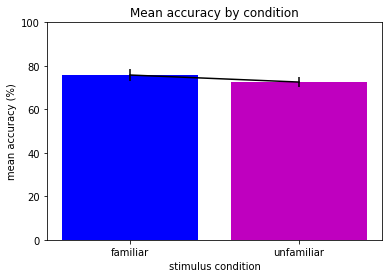

In [14]:
#print the basics
print("Familiar accuracy = "+str(np.nanmean(meanAcc_learned))," Unfamiliar accuracy = "+str(np.nanmean(meanAcc_novel)))

#ttest of mean accuracy distributions between familiar and unfamiliar stimuli
print("Familiar vs unfamiliar acc ttest: ",np.round(stats.ttest_rel(np.nanmean(meanAcc_learned,1),np.nanmean(meanAcc_novel,1),nan_policy='omit'),6))
#plot difference between familiar and unfamiliar accuracy means
fig = plt.figure()
plt.bar([0,1],[np.nanmean(meanAcc_learned),np.nanmean(meanAcc_novel)],color=['blue','m'])
#error term is SEM
plt.errorbar([0,1],[np.nanmean(meanAcc_learned),np.nanmean(meanAcc_novel)],yerr=[np.nanstd(np.nanmean(meanAcc_learned,1))/np.sqrt(nsubj),np.nanstd(np.nanmean(meanAcc_novel,1))/np.sqrt(nsubj)],color='k')
plt.xlabel("stimulus condition")
plt.xticks([0,1],["familiar","unfamiliar"])
plt.ylabel("mean accuracy (%)")
plt.yticks([0,.2,.4,.6,.8,1],[0,20,40,60,80,100])
plt.title("Mean accuracy by condition")
#plt.scatter([0.5],[.8],marker='*',color='k')
if save_plot:
	plt.savefig(figure_dir+'acc_diff_familiar_vs_nonfamiliar.pdf',format='pdf')
if show_plot:
	plt.show()

In [15]:
####### Plot distribution of responses by condition #######

Familiar vs unfamiliar target resps ttest:  [1.78705  0.092887]
Familiar vs unfamiliar competitor resps ttest:  [-2.074851  0.054491]
Familiar vs unfamiliar noncompetitor resps ttest:  [1.208081 0.24457 ]
Familiar anova:  F_onewayResult(statistic=47.66512642360045, pvalue=4.0444180105518607e-13)
Unfamiliar anova:  F_onewayResult(statistic=44.67132884202297, pvalue=1.3152891576527635e-12)


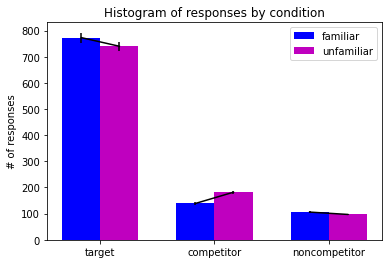

In [16]:
#plot histograms of responses for each condition
#ttest between familiar and unfamiliar target #dunno why I did this but it looks pretty I guess
print("Familiar vs unfamiliar target resps ttest: ",np.round(stats.ttest_rel(np.sum(histData_learned,2)[:,0],np.sum(histData_novel,2)[:,0],nan_policy='omit'),6))
#ttest between familiar and unfamiliar competitor
print("Familiar vs unfamiliar competitor resps ttest: ",np.round(stats.ttest_rel(np.sum(histData_learned,2)[:,1],np.sum(histData_novel,2)[:,1],nan_policy='omit'),6))
#ttest between familiar and unfamiliar noncompetitor
print("Familiar vs unfamiliar noncompetitor resps ttest: ",np.round(stats.ttest_rel(np.sum(histData_learned,2)[:,2],np.sum(histData_novel,2)[:,2],nan_policy = 'omit'),6))
#anova between familiar responses 
print("Familiar anova: ",stats.f_oneway(np.nansum(histData_learned,2)[:,0],np.nansum(histData_learned,2)[:,1],np.nansum(histData_learned,2)[:,2],axis=0))
#anova between unfamiliar responses 
print("Unfamiliar anova: ",stats.f_oneway(np.nansum(histData_novel,2)[:,0],np.nansum(histData_novel,2)[:,1],np.nansum(histData_novel,2)[:,2],axis=0))
#plot
fig = plt.figure()
#collapse across subjects
histAllsubj_learned = np.nansum(histData_learned,0)
histAllsubj_novel = np.nansum(histData_novel,0)
c1 = plt.bar([0,1.5,3],[np.nansum(histAllsubj_learned[0]),np.nansum(histAllsubj_learned[1]),np.nansum(histAllsubj_learned[2])],width=.5,color='b')
c2 = plt.bar([.5,2,3.5],[np.nansum(histAllsubj_novel[0]),np.nansum(histAllsubj_novel[1]),np.nansum(histAllsubj_novel[2])],width=.5,color='m')
#compute error term (will be len(3) array)
learned_hist_err = np.std(np.nansum(histData_learned,2),0)
novel_hist_err = np.std(np.nansum(histData_novel,2),0)
#plot
plt.errorbar([0,.5],[np.nansum(histAllsubj_learned[0]),np.nansum(histAllsubj_novel[0])],yerr=[learned_hist_err[0],novel_hist_err[0]],color='k')
plt.errorbar([1.5,2],[np.nansum(histAllsubj_learned[1]),np.nansum(histAllsubj_novel[1])],yerr=[learned_hist_err[1],novel_hist_err[1]],color='k')
plt.errorbar([3,3.5],[np.nansum(histAllsubj_learned[2]),np.nansum(histAllsubj_novel[2])],yerr=[learned_hist_err[2],novel_hist_err[2]],color='k')
plt.legend([c1,c2],['familiar','unfamiliar'])
plt.xticks([.25,1.75,3.25],['target','competitor','noncompetitor'])
plt.ylabel('# of responses')
plt.title("Histogram of responses by condition")
plt.savefig(figure_dir+'response_histograms.pdf',format='pdf')
plt.show()

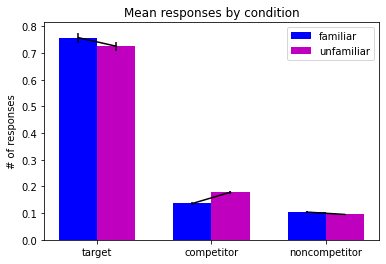

In [17]:
#plot histogrm but as a mean
totTrials = (120*nsubj)/2
fig = plt.figure()
#collapse across subjects
histAllsubj_learned = np.nansum(histData_learned,0)
histAllsubj_novel = np.nansum(histData_novel,0)
c1 = plt.bar([0,1.5,3],[np.nansum(histAllsubj_learned[0])/totTrials,np.nansum(histAllsubj_learned[1])/totTrials,np.nansum(histAllsubj_learned[2])/totTrials],width=.5,color='b')
c2 = plt.bar([.5,2,3.5],[np.nansum(histAllsubj_novel[0])/totTrials,np.nansum(histAllsubj_novel[1])/totTrials,np.nansum(histAllsubj_novel[2])/totTrials],width=.5,color='m')
#compute error term (will be len(3) array)
learned_hist_err = np.std(np.nansum(histData_learned,2)/totTrials,0)
novel_hist_err = np.std(np.nansum(histData_novel,2)/totTrials,0)
#plot
plt.errorbar([0,.5],[np.nansum(histAllsubj_learned[0])/totTrials,np.nansum(histAllsubj_novel[0])/totTrials],yerr=[learned_hist_err[0],novel_hist_err[0]],color='k')
plt.errorbar([1.5,2],[np.nansum(histAllsubj_learned[1])/totTrials,np.nansum(histAllsubj_novel[1])/totTrials],yerr=[learned_hist_err[1],novel_hist_err[1]],color='k')
plt.errorbar([3,3.5],[np.nansum(histAllsubj_learned[2])/totTrials,np.nansum(histAllsubj_novel[2])/totTrials],yerr=[learned_hist_err[2],novel_hist_err[2]],color='k')
plt.legend([c1,c2],['familiar','unfamiliar'])
plt.xticks([.25,1.75,3.25],['target','competitor','noncompetitor'])
plt.ylabel('# of responses')
plt.title("Mean responses by condition")
plt.savefig(figure_dir+'response_means.pdf',format='pdf')
plt.show()

In [18]:
###### nback performance over blocks #######

nback block acc ttest:  Ttest_relResult(statistic=-6.723094525588643, pvalue=4.893914598373625e-06)


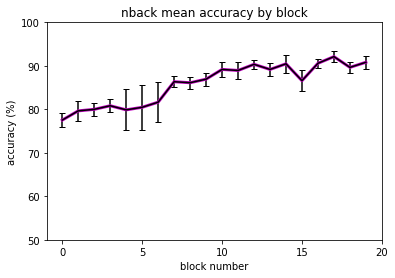

In [19]:
#plot nback acc as a function of blocks
#ttest between blocks 1 and 20
print("nback block acc ttest: ",stats.ttest_rel(meanAcc_nback[:,0],meanAcc_nback[:,19],nan_policy='omit'))
#plot
fig = plt.figure()
plt.plot(np.arange(0,20),np.nanmean(meanAcc_nback,0),color='m',linewidth=3)
#error is sem
plt.errorbar(np.arange(0,20),np.nanmean(meanAcc_nback,0),yerr=np.nanstd(meanAcc_nback,0)/np.sqrt(nsubj),color='k',capsize=3)
plt.yticks([0.5,0.6,0.7,0.8,0.9,1],[50,60,70,80,90,100])
#plt.scatter([0.5,2.5,9.5],[1,1,1],marker='*',color='k')
plt.ylabel('accuracy (%)')
plt.xlabel('block number')
plt.xticks([0,5,10,15,20])
plt.title('nback mean accuracy by block')
plt.savefig(figure_dir+'nback_acc_blockwise.pdf',format='pdf')
plt.show()
#subjects messed up the bottons 2x
#block 14 was caused by subj13
#block 20 was caused by subj3

nback block rt ttest:  Ttest_relResult(statistic=4.176565232941579, pvalue=0.0007125836959429869)


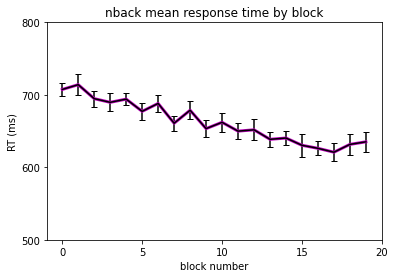

In [20]:
#RTs, cause why not
#ttest between blocks 1 and 20
print("nback block rt ttest: ",stats.ttest_rel(meanRT_nback[:,0],meanRT_nback[:,19],nan_policy='omit'))
fig = plt.figure()
plt.plot(np.arange(0,20),np.nanmean(meanRT_nback,0),color='m',linewidth=3)
#error is std
plt.errorbar(np.arange(0,20),np.nanmean(meanRT_nback,0),yerr=np.nanstd(meanRT_nback,0)/np.sqrt(nsubj),color='k',capsize=3)
plt.yticks([0.5,0.6,0.7,0.8],[500,600,700,800])
#plt.scatter([0.5,2.5,9.5],[1,1,1],marker='*',color='k')
plt.ylabel('RT (ms)')
plt.xlabel('block number')
plt.xticks([0,5,10,15,20])
plt.title('nback mean response time by block')
plt.savefig(figure_dir+'nback_rt_blockwise.pdf',format='pdf')
plt.show()

In [21]:
###### correlations between nback performance and association acc ########

Pearson r of across subject correlation of nback and familiar acc:  0.36512 0.14956


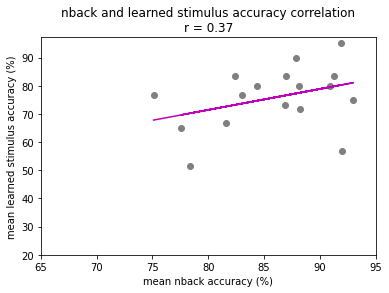

In [22]:
#across subject correlation of nback acc and learned acc
#remove nans from data
clean_meanAcc_nback = meanAcc_nback[~np.isnan(meanAcc_nback[:,1])]
clean_meanAcc_novel = meanAcc_novel[~np.isnan(meanAcc_novel[:,1])]
clean_meanAcc_learned = meanAcc_learned[~np.isnan(meanAcc_learned[:,1])]
[r,p] = stats.pearsonr(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_learned,1))
print("Pearson r of across subject correlation of nback and familiar acc: ",np.round(r,5),np.round(p,5))
[m,b] = np.polyfit(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_learned,1),1)
fig = plt.figure()
plt.scatter(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_learned,1),color='gray')
plt.plot(np.nanmean(clean_meanAcc_nback,1),m*np.nanmean(clean_meanAcc_nback,1)+b,color='m')
plt.xlabel('mean nback accuracy (%)')
plt.ylabel('mean learned stimulus accuracy (%)')
plt.yticks([.2,.3,.4,.5,.6,.7,.8,.9],[20,30,40,50,60,70,80,90])
plt.xticks([.65,.7,.75,.8,.85,.9,.95],[65,70,75,80,85,90,95])
plt.title('nback and learned stimulus accuracy correlation\nr = '+str(np.round(r,2)))
plt.savefig(figure_dir+'famAcc_correlation.pdf',format='pdf')
plt.show()

Pearson r of across subject correlation of nback and unfamiliar acc:  0.52858 0.02916


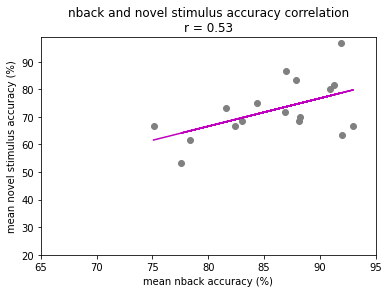

In [23]:
#across subject correlation of nback and novel acc
[r,p] = stats.pearsonr(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_novel,1))
print("Pearson r of across subject correlation of nback and unfamiliar acc: ",np.round(r,5),np.round(p,5))
[m,b] = np.polyfit(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_novel,1),1)
fig = plt.figure()
plt.scatter(np.nanmean(clean_meanAcc_nback,1),np.nanmean(clean_meanAcc_novel,1),color='gray')
plt.plot(np.nanmean(clean_meanAcc_nback,1),m*np.nanmean(clean_meanAcc_nback,1)+b,color='m')
plt.xlabel('mean nback accuracy (%)')
plt.ylabel('mean novel stimulus accuracy (%)')
plt.yticks([.2,.3,.4,.5,.6,.7,.8,.9],[20,30,40,50,60,70,80,90])
plt.xticks([.65,.7,.75,.8,.85,.9,.95],[65,70,75,80,85,90,95])
plt.title('nback and novel stimulus accuracy correlation\nr = '+str(np.round(r,2)))
plt.savefig(figure_dir+'unfamAcc_correlation.pdf',format='pdf')
plt.show()

In [24]:
###### Look at response times for the association task #######

Familiar rts = 1.3023467096252075  Unfamiliar rts = 1.367428701956601
Familiar vs unfamiliar rt ttest:  [-1.528167  0.145998]


/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1322923108.py:4: RuntimeWarning: Mean of empty slice
  print("Familiar vs unfamiliar rt ttest: ",np.round(stats.ttest_rel(np.nanmean(meanRT_learned,1),np.nanmean(meanRT_novel,1),nan_policy='omit'),6))
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1322923108.py:9: RuntimeWarning: Mean of empty slice
  plt.errorbar([0,1],[np.nanmean(meanRT_learned),np.nanmean(meanRT_novel)],yerr=[np.nanstd(np.nanmean(meanRT_learned,1))/np.sqrt(nsubj),np.nanstd(np.nanmean(meanRT_novel,1))/np.sqrt(nsubj)],color='k')


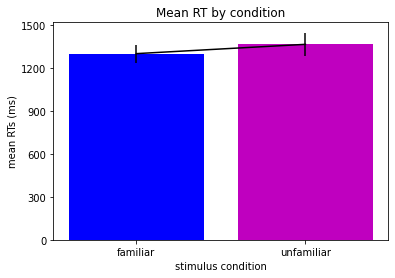

In [25]:
#plot rts for study test
print("Familiar rts = "+str(np.nanmean(meanRT_learned))," Unfamiliar rts = "+str(np.nanmean(meanRT_novel)))
#ttest of mean accuracy distributions between familiar and unfamiliar stimuli
print("Familiar vs unfamiliar rt ttest: ",np.round(stats.ttest_rel(np.nanmean(meanRT_learned,1),np.nanmean(meanRT_novel,1),nan_policy='omit'),6))
#plot difference between familiar and unfamiliar accuracy means
fig = plt.figure()
plt.bar([0,1],[np.nanmean(meanRT_learned),np.nanmean(meanRT_novel)],color=['blue','m'])
#error term is SEM
plt.errorbar([0,1],[np.nanmean(meanRT_learned),np.nanmean(meanRT_novel)],yerr=[np.nanstd(np.nanmean(meanRT_learned,1))/np.sqrt(nsubj),np.nanstd(np.nanmean(meanRT_novel,1))/np.sqrt(nsubj)],color='k')
plt.xlabel("stimulus condition")
plt.xticks([0,1],["familiar","unfamiliar"])
plt.ylabel("mean RTs (ms)")
plt.yticks([0,.3,.6,.9,1.2,1.5],[0,300,600,900,1200,1500])
plt.title("Mean RT by condition")
#plt.scatter([0.5],[1.5],marker='*',color='k')
plt.savefig(figure_dir+'rt_diff_familiar_vs_nonfamiliar.pdf',format='pdf')
plt.show()

Familiar vs unfamiliar target rt ttest:  [-1.813687  0.088525]
Familiar vs unfamiliar competitor rt ttest:  [-1.571987  0.167013]
Familiar vs unfamiliar noncompetitor rt ttest:  [-0.661316  0.576405]
Familiar anova:  F_onewayResult(statistic=nan, pvalue=nan)
Unfamiliar anova:  F_onewayResult(statistic=nan, pvalue=nan)


/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1245808779.py:8: RuntimeWarning: Mean of empty slice
  print("Familiar anova: ",stats.f_oneway(np.nansum(histData_learned,2)[:,0],np.nanmean(rtData_learned,2)[:,1],np.nanmean(rtData_learned,2)[:,2],axis=0))
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1245808779.py:10: RuntimeWarning: Mean of empty slice
  print("Unfamiliar anova: ",stats.f_oneway(np.nansum(histData_novel,2)[:,0],np.nanmean(rtData_novel,2)[:,1],np.nanmean(rtData_novel,2)[:,2],axis=0))
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1245808779.py:13: RuntimeWarning: Mean of empty slice
  rtData_learned_blockmean = np.nanmean(rtData_learned,2)
/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/1245808779.py:14: RuntimeWarning: Mean of empty slice
  rtData_novel_blockmean = np.nanmean(rtData_novel,2)


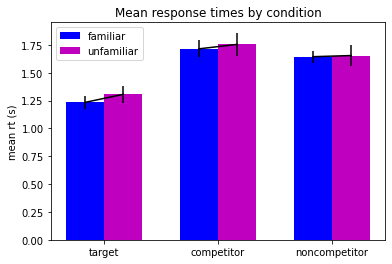

In [26]:
#plot mean respone times split by responses
print("Familiar vs unfamiliar target rt ttest: ",np.round(stats.ttest_rel(np.mean(rtData_learned,2)[:,0],np.mean(rtData_novel,2)[:,0],nan_policy='omit'),6))
#ttest between familiar and unfamiliar competitor
print("Familiar vs unfamiliar competitor rt ttest: ",np.round(stats.ttest_rel(np.mean(rtData_learned,2)[:,1],np.mean(rtData_novel,2)[:,1],nan_policy='omit'),6))
#ttest between familiar and unfamiliar noncompetitor
print("Familiar vs unfamiliar noncompetitor rt ttest: ",np.round(stats.ttest_rel(np.mean(rtData_learned,2)[:,2],np.mean(rtData_novel,2)[:,2],nan_policy = 'omit'),6))
#anova between familiar responses 
print("Familiar anova: ",stats.f_oneway(np.nansum(histData_learned,2)[:,0],np.nanmean(rtData_learned,2)[:,1],np.nanmean(rtData_learned,2)[:,2],axis=0))
#anova between unfamiliar responses 
print("Unfamiliar anova: ",stats.f_oneway(np.nansum(histData_novel,2)[:,0],np.nanmean(rtData_novel,2)[:,1],np.nanmean(rtData_novel,2)[:,2],axis=0))
fig = plt.figure()
#collapse across subjects
rtData_learned_blockmean = np.nanmean(rtData_learned,2)
rtData_novel_blockmean = np.nanmean(rtData_novel,2)
c1 = plt.bar([0,1.5,3],[np.nanmean(rtData_learned_blockmean[:,0]),np.nanmean(rtData_learned_blockmean[:,1]),np.nanmean(rtData_learned_blockmean[:,2])],width=.5,color='b')
c2 = plt.bar([.5,2,3.5],[np.nanmean(rtData_novel_blockmean[:,0]),np.nanmean(rtData_novel_blockmean[:,1]),np.nanmean(rtData_novel_blockmean[:,2])],width=.5,color='m')
#compute error term (will be len(3) array)
learned_rt_err = np.nanstd(rtData_learned_blockmean,0)/np.sqrt(nsubj)
novel_rt_err = np.nanstd(rtData_novel_blockmean,0)/np.sqrt(nsubj)
#plot
plt.errorbar([0,.5],[np.nanmean(rtData_learned_blockmean[:,0]),np.nanmean(rtData_novel_blockmean[:,0])],yerr=[learned_rt_err[0],novel_rt_err[0]],color='k')
plt.errorbar([1.5,2],[np.nanmean(rtData_learned_blockmean[:,1]),np.nanmean(rtData_novel_blockmean[:,1])],yerr=[learned_rt_err[1],novel_rt_err[1]],color='k')
plt.errorbar([3,3.5],[np.nanmean(rtData_learned_blockmean[:,2]),np.nanmean(rtData_novel_blockmean[:,2])],yerr=[learned_rt_err[2],novel_rt_err[2]],color='k')
plt.legend([c1,c2],['familiar','unfamiliar'])
plt.xticks([.25,1.75,3.25],['target','competitor','noncompetitor'])
plt.ylabel('mean rt (s)')
plt.title("Mean response times by condition")
plt.savefig(figure_dir+'responsetime_means.pdf',format='pdf')
plt.show()

In [27]:
######## Look at blockwise performance on the association task ########

Familiar vs unfamiliar block 1 acc ttest:  [2.13498  0.048575]
Familiar vs unfamiliar block 2 acc ttest:  [1.627703 0.123117]
Familiar vs unfamiliar block 3 acc ttest:  [-0.473879  0.641988]


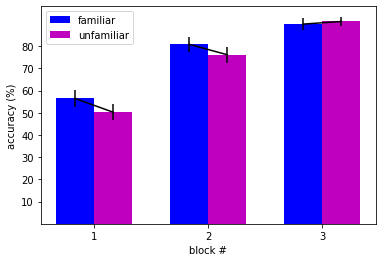

0.8999999999999999 0.911764705882353


In [28]:
#ttests between condition means per block
print("Familiar vs unfamiliar block 1 acc ttest: ",np.round(stats.ttest_rel(meanAcc_learned[:,0],meanAcc_novel[:,0],nan_policy='omit'),6))
print("Familiar vs unfamiliar block 2 acc ttest: ",np.round(stats.ttest_rel(meanAcc_learned[:,1],meanAcc_novel[:,1],nan_policy='omit'),6))
print("Familiar vs unfamiliar block 3 acc ttest: ",np.round(stats.ttest_rel(meanAcc_learned[:,2],meanAcc_novel[:,2],nan_policy='omit'),6))
#plot the mean accuracy by block
fig = plt.figure()
c1 = plt.bar([0,1.5,3],np.nanmean(meanAcc_learned,0),width=.5,color='b')
c2 = plt.bar([.5,2,3.5],np.nanmean(meanAcc_novel,0),width=.5,color='m')
plt.errorbar([0,.5],[np.nanmean(meanAcc_learned,0)[0],np.nanmean(meanAcc_novel,0)[0]],yerr=[np.nanstd(meanAcc_learned,0)[0]/np.sqrt(nsubj),np.nanstd(meanAcc_novel,0)[0]/np.sqrt(nsubj)],color='k')
plt.errorbar([1.5,2],[np.nanmean(meanAcc_learned,0)[1],np.nanmean(meanAcc_novel,0)[1]],yerr=[np.nanstd(meanAcc_learned,0)[1]/np.sqrt(nsubj),np.nanstd(meanAcc_novel,0)[1]/np.sqrt(nsubj)],color='k')
plt.errorbar([3,3.5],[np.nanmean(meanAcc_learned,0)[2],np.nanmean(meanAcc_novel,0)[2]],yerr=[np.nanstd(meanAcc_learned,0)[2]/np.sqrt(nsubj),np.nanstd(meanAcc_novel,0)[2]/np.sqrt(nsubj)],color='k')
plt.xlabel('block #')
plt.xticks([.25,1.75,3.25],[1,2,3])
plt.ylabel('accuracy (%)')
plt.yticks([.1,.2,.3,.4,.5,.6,.7,.8],[10,20,30,40,50,60,70,80])
plt.legend([c1,c2],['familiar','unfamiliar'])
plt.savefig(figure_dir+'assoc_acc_by_block.pdf',format='pdf')
plt.show()
print(np.nanmean(meanAcc_learned[:,2]),np.nanmean(meanAcc_novel[:,2]))

first block n =  15.0
first block acc cutoff =  0.45
15.0
Familiar vs unfamiliar block 1 acc ttest:  [2.12132  0.046584]


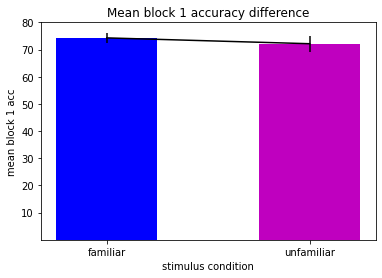

In [29]:
#exclude underperformers in the first block
n = np.sum(fb_select)
print("first block n = ",str(n))
print("first block acc cutoff = ",str(fb_cutoff))
fb_select = fb_select.astype(int)
print(n)
print("Familiar vs unfamiliar block 1 acc ttest: ",np.round(stats.ttest_rel(meanAcc_learned[fb_select,0],meanAcc_novel[fb_select,0],nan_policy='omit'),6))
#plot the mean accuracy by block
fig = plt.figure()
plt.bar([0,1],[np.nanmean(meanAcc_learned[fb_select,0]),np.nanmean(meanAcc_novel[fb_select,0])],width=.5,color=['b','m'])
plt.errorbar([0,1],[np.nanmean(meanAcc_learned[fb_select,0]),np.nanmean(meanAcc_novel[fb_select,0])],yerr=[np.nanstd(meanAcc_learned[fb_select,0])/np.sqrt(n),np.nanstd(meanAcc_novel[fb_select,0])/np.sqrt(n)],color='k')
plt.xlabel("stimulus condition")
plt.xticks([0,1],["familiar","unfamiliar"])
plt.ylabel("mean block 1 acc")
plt.yticks([.1,.2,.3,.4,.5,.6,.7,.8],[10,20,30,40,50,60,70,80])
plt.title("Mean block 1 accuracy difference")
#plt.scatter([0.5],[1.5],marker='*',color='k')
plt.savefig(figure_dir+'acc_first_block_exclusion.pdf',format='pdf')
plt.show()

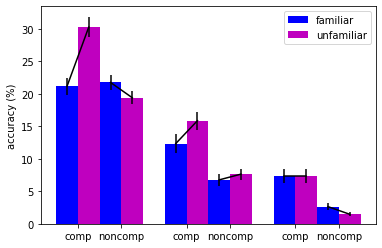

In [30]:
#look at competitor vs noncompetitor
blockTrials = (40*nsubj)/2
histAllsubj_learned = np.nansum(histData_learned,0)
histAllsubj_novel = np.nansum(histData_novel,0)
fig = plt.figure()
c1 = plt.bar([0,2.5,5],histAllsubj_learned[1]/blockTrials,color='b',width=.5)
c2 = plt.bar([1,3.5,6],histAllsubj_learned[2]/blockTrials,color='b',width=.5)
c3 = plt.bar([.5,3,5.5],histAllsubj_novel[1]/blockTrials,color='m',width=.5)
c4 = plt.bar([1.5,4,6.5],histAllsubj_novel[2]/blockTrials,color='m',width=.5)
learned_hist_err = np.nanstd(histData_learned/40,0)/np.sqrt(nsubj)
novel_hist_err = np.nanstd(histData_novel/40,0)/np.sqrt(nsubj)
plt.errorbar([0,.5],[histAllsubj_learned[1,0]/blockTrials,histAllsubj_novel[1,0]/blockTrials],yerr=[learned_hist_err[1,0],novel_hist_err[1,0]],color='k')
plt.errorbar([1,1.5],[histAllsubj_learned[2,0]/blockTrials,histAllsubj_novel[2,0]/blockTrials],yerr=[learned_hist_err[2,0],novel_hist_err[2,0]],color='k')
plt.errorbar([2.5,3],[histAllsubj_learned[1,1]/blockTrials,histAllsubj_novel[1,1]/blockTrials],yerr=[learned_hist_err[1,1],novel_hist_err[1,1]],color='k')
plt.errorbar([3.5,4],[histAllsubj_learned[2,1]/blockTrials,histAllsubj_novel[2,1]/blockTrials],yerr=[learned_hist_err[2,1],novel_hist_err[2,1]],color='k')
plt.errorbar([5,5.5],[histAllsubj_learned[1,2]/blockTrials,histAllsubj_novel[1,2]/blockTrials],yerr=[learned_hist_err[1,2],novel_hist_err[1,2]],color='k')
plt.errorbar([6,6.5],[histAllsubj_learned[2,2]/blockTrials,histAllsubj_novel[2,2]/blockTrials],yerr=[learned_hist_err[2,2],novel_hist_err[2,2]],color='k')
plt.xticks([.25,1.25,2.75,3.75,5.25,6.25],['comp','noncomp','comp','noncomp','comp','noncomp'])
plt.yticks([0,.05,.1,.15,.2,.25,.3],[0,5,10,15,20,25,30])
plt.ylabel("accuracy (%)")
plt.legend([c1,c3],['familiar','unfamiliar'])
plt.savefig(figure_dir+'comp_vs_nocomp_blockwise.pdf',format='pdf')
plt.show()

In [31]:
####### check that gazebos arent just easier to learn than beaches ######
print('beachs vs gaxebos ttest: ',stats.ttest_rel(np.nanmean(meanAcc_learned[category_learned==0],1),np.nanmean(meanAcc_learned[category_learned==1],1),nan_policy='omit'))
fig = plt.figure()
plt.bar([0,1],[np.nanmean(meanAcc_learned[category_learned==0]),np.nanmean(meanAcc_learned[category_learned==1])],color=['b','g'])
plt.errorbar([0,1],[np.nanmean(meanAcc_learned[category_learned==0]),np.nanmean(meanAcc_learned[category_learned==1])],yerr=[np.nanstd(np.nanmean(meanAcc_learned[category_learned==0],1),0)/np.sqrt(nsubj),np.nanstd(np.nanmean(meanAcc_learned[category_learned==1],1),0)/np.sqrt(nsubj)])
plt.xticks([0,1],['beaches','gazebos'])
plt.show()

/var/folders/9d/64h6bpdx6wld4v9tw1jq1yqr0000gp/T/ipykernel_2195/3303668206.py:2: RuntimeWarning: Mean of empty slice
  print('beachs vs gaxebos ttest: ',stats.ttest_rel(np.nanmean(meanAcc_learned[category_learned==0],1),np.nanmean(meanAcc_learned[category_learned==1],1),nan_policy='omit'))


ValueError: operands could not be broadcast together with shapes (11,) (10,) 

In [32]:
import os

os.system('jupyter nbconvert --to html marshmalloogalooAnalysis.ipynb')

[NbConvertApp] Converting notebook marshmalloogalooAnalysis.ipynb to html
[NbConvertApp] Writing 963321 bytes to marshmalloogalooAnalysis.html


0